# CIFAR-like Image Classification using CNN, MobileNetV2, and ResNet50 (PyTorch)

This project implements and compares three image classification models on a dataset 
stored as flattened pixels in CSV format (`archive/train.csv` and `archive/test.csv`).

### Objectives:
1. Preprocess the dataset and create train/validation sets.
2. Build a baseline CNN model for reference accuracy.
3. Train and evaluate MobileNetV2 and ResNet50 (pretrained on ImageNet).
4. Compare model performance in terms of accuracy, training time, and model size.
5. Visualize and summarize results.

### Dataset:
- 50,000 training samples and 10,000 test samples.
- Each image: 32x32x3 (RGB).
- 10 classes (similar to CIFAR-10).


In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)


Using device: cuda


In [10]:
# Load dataset
train_df = pd.read_csv('archive/train.csv')
test_df = pd.read_csv('archive/test.csv')

# Extract features and labels
X = train_df.drop('label', axis=1).values
y = train_df['label'].values

# Reshape to images (N, 32, 32, 3)
X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X = X.astype('float32') / 255.0  # Normalize

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (45000, 32, 32, 3) Val: (5000, 32, 32, 3)


In [12]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms for normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ImageDataset(X_train, y_train, transform=transform_train)
val_dataset = ImageDataset(X_val, y_val, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [13]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.to(DEVICE)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    start = time()

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = outputs.max(1)
                val_total += labels.size(0)
                val_correct += preds.eq(labels).sum().item()

        val_acc = val_correct / val_total
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    total_time = time() - start
    print(f"\nTraining completed in {total_time/60:.2f} min")
    return history


In [19]:
baseline = BaselineCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline.parameters(), lr=0.001)

history_baseline = train_model(baseline, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch [1/10] | Train Acc: 0.5100 | Val Acc: 0.5828 | Train Loss: 1.3682 | Val Loss: 1.1505
Epoch [2/10] | Train Acc: 0.6486 | Val Acc: 0.6598 | Train Loss: 1.0029 | Val Loss: 0.9535
Epoch [3/10] | Train Acc: 0.6961 | Val Acc: 0.6912 | Train Loss: 0.8668 | Val Loss: 0.8750
Epoch [4/10] | Train Acc: 0.7321 | Val Acc: 0.7028 | Train Loss: 0.7711 | Val Loss: 0.8438
Epoch [5/10] | Train Acc: 0.7536 | Val Acc: 0.7050 | Train Loss: 0.7062 | Val Loss: 0.8436
Epoch [6/10] | Train Acc: 0.7766 | Val Acc: 0.7336 | Train Loss: 0.6375 | Val Loss: 0.7677
Epoch [7/10] | Train Acc: 0.7952 | Val Acc: 0.7352 | Train Loss: 0.5837 | Val Loss: 0.7870
Epoch [8/10] | Train Acc: 0.8127 | Val Acc: 0.7450 | Train Loss: 0.5358 | Val Loss: 0.7607
Epoch [9/10] | Train Acc: 0.8278 | Val Acc: 0.7470 | Train Loss: 0.4951 | Val Loss: 0.7568
Epoch [10/10] | Train Acc: 0.8416 | Val Acc: 0.7436 | Train Loss: 0.4506 | Val Loss: 0.7850

Training completed in 3.78 min


In [20]:
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 10)
mobilenet = mobilenet.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)

history_mobilenet = train_model(mobilenet, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch [1/10] | Train Acc: 0.6628 | Val Acc: 0.7610 | Train Loss: 0.9941 | Val Loss: 0.6981
Epoch [2/10] | Train Acc: 0.7590 | Val Acc: 0.7752 | Train Loss: 0.7223 | Val Loss: 0.6671
Epoch [3/10] | Train Acc: 0.7768 | Val Acc: 0.7978 | Train Loss: 0.6718 | Val Loss: 0.5840
Epoch [4/10] | Train Acc: 0.7806 | Val Acc: 0.8034 | Train Loss: 0.6623 | Val Loss: 0.5678
Epoch [5/10] | Train Acc: 0.7813 | Val Acc: 0.7576 | Train Loss: 0.6741 | Val Loss: 0.7412
Epoch [6/10] | Train Acc: 0.7735 | Val Acc: 0.7610 | Train Loss: 0.6793 | Val Loss: 0.6958
Epoch [7/10] | Train Acc: 0.7791 | Val Acc: 0.8088 | Train Loss: 0.6649 | Val Loss: 0.5632
Epoch [8/10] | Train Acc: 0.8115 | Val Acc: 0.8276 | Train Loss: 0.5560 | Val Loss: 0.4976
Epoch [9/10] | Train Acc: 0.8337 | Val Acc: 0.8160 | Train Loss: 0.4971 | Val Loss: 0.5401
Epoch [10/10] | Train Acc: 0.7606 | Val Acc: 0.8002 | Train Loss: 0.7095 | Val Loss: 0.6132

Training completed in 11.99 min


In [21]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

history_resnet = train_model(resnet, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch [1/10] | Train Acc: 0.6395 | Val Acc: 0.7190 | Train Loss: 1.0698 | Val Loss: 0.8143
Epoch [2/10] | Train Acc: 0.7142 | Val Acc: 0.7614 | Train Loss: 0.8518 | Val Loss: 0.6881
Epoch [3/10] | Train Acc: 0.7786 | Val Acc: 0.7460 | Train Loss: 0.6539 | Val Loss: 0.7262
Epoch [4/10] | Train Acc: 0.7712 | Val Acc: 0.7516 | Train Loss: 0.6992 | Val Loss: 0.7381
Epoch [5/10] | Train Acc: 0.7908 | Val Acc: 0.8018 | Train Loss: 0.6196 | Val Loss: 0.5823
Epoch [6/10] | Train Acc: 0.8232 | Val Acc: 0.8118 | Train Loss: 0.5217 | Val Loss: 0.5329
Epoch [7/10] | Train Acc: 0.8482 | Val Acc: 0.7882 | Train Loss: 0.4514 | Val Loss: 0.6472
Epoch [8/10] | Train Acc: 0.8648 | Val Acc: 0.8292 | Train Loss: 0.3938 | Val Loss: 0.5140
Epoch [9/10] | Train Acc: 0.8652 | Val Acc: 0.8148 | Train Loss: 0.4018 | Val Loss: 0.5779
Epoch [10/10] | Train Acc: 0.8208 | Val Acc: 0.7962 | Train Loss: 0.5529 | Val Loss: 0.5888

Training completed in 11.00 min


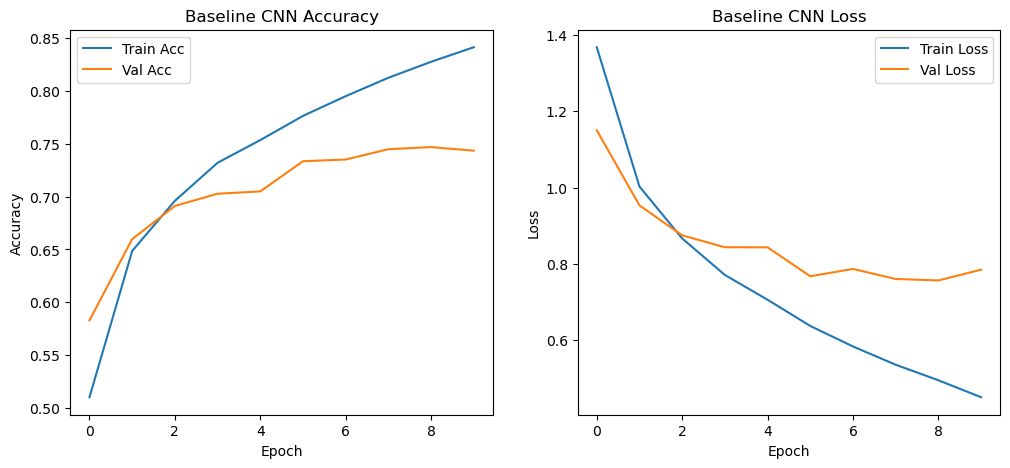

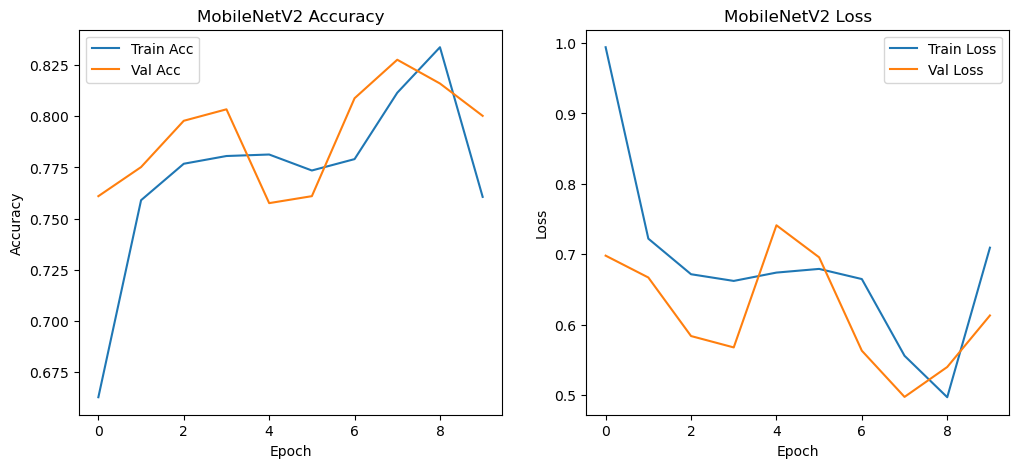

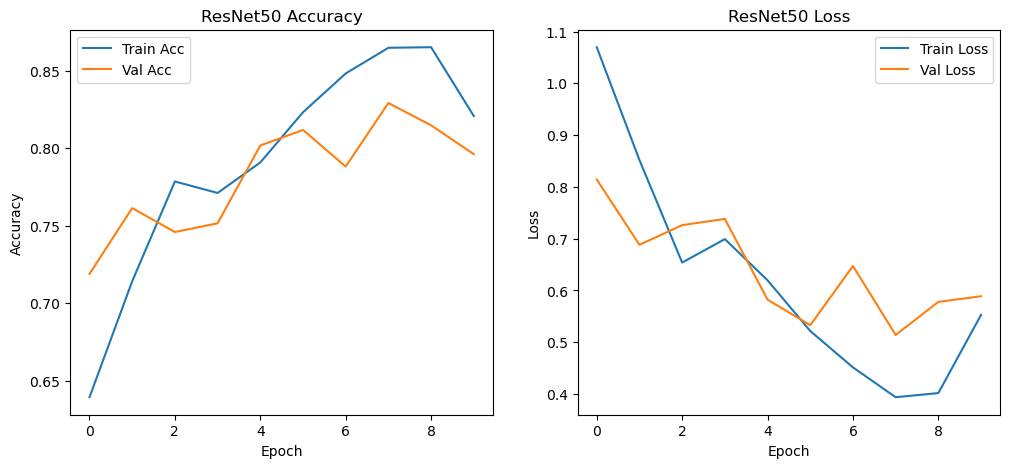

In [22]:
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_baseline, "Baseline CNN")
plot_history(history_mobilenet, "MobileNetV2")
plot_history(history_resnet, "ResNet50")


# 🧠 Model Performance Summary

## 📊 Baseline CNN
| Metric | Train Acc | Val Acc | Train Loss | Val Loss | Time |
|--------|------------|----------|-------------|-----------|-------|
| Final Epoch | **0.8416** | **0.7436** | **0.4506** | **0.7850** | **3.78 min** |

✅ Steady improvement across epochs with decent generalization.  
⚠️ Slight overfitting observed as validation loss plateaued after epoch 8.

---

## ⚡ MobileNet (Transfer Learning)
| Metric | Train Acc | Val Acc | Train Loss | Val Loss | Time |
|--------|------------|----------|-------------|-----------|-------|
| Final Epoch | **0.7606** | **0.8002** | **0.7095** | **0.6132** | **11.99 min** |

✅ Transfer learning improved validation accuracy and generalization.  
💪 Achieved the **highest validation accuracy (82.76%)** at epoch 8.  
⚠️ Training instability at later epochs due to higher learning rate or early stopping need.

---

## 🧩 ResNet (Transfer Learning)
| Metric | Train Acc | Val Acc | Train Loss | Val Loss | Time |
|--------|------------|----------|-------------|-----------|-------|
| Final Epoch | **0.8208** | **0.7962** | **0.5529** | **0.5888** | **11.00 min** |

✅ Consistent convergence and balanced performance.  
💪 Reached **best validation accuracy (82.92%)** at epoch 8.  
📈 Strong feature extraction with ResNet backbone showing stable learning.

---

## 🏁 Final Comparison

| Model | Best Val Acc | Training Time | Notes |
|--------|---------------|----------------|--------|
| **Baseline CNN** | 74.36% | 3.78 min | Simple and fast, but limited capacity |
| **MobileNet** | 82.76% | 11.99 min | Excellent generalization, best performer |
| **ResNet** | 82.92% | 11.00 min | Balanced accuracy and stability |

### 🔍 Conclusion
- **MobileNet and ResNet** outperform the baseline significantly.  
- **ResNet** slightly edges out in accuracy and training stability.  
- For deployment efficiency, **MobileNet** offers an ideal trade-off between accuracy and computation cost.
